In [1]:
"""
processing data on Uniswap V2 and its forks. 
"""
import os
from dotenv import load_dotenv
from datetime import datetime, timezone
import web3
from decimal import Decimal
import time
import pandas as pd
import polars as pl
import numpy as np
from utils import *
import matplotlib.pyplot as plt

load_dotenv()

True

In [2]:
network = "MAINNET"
dex = "UNI_V2"
base_token = "WETH"
quote_token = "USDT"
fee = 30  # in bps
use_instant_volatility = False
interval = 1800  # 30 minutes
window = 48  # 24 hours

In [3]:
############################################################
#                        read files                        #
############################################################

events_df = pd.read_csv(
    f"data/onchain_events/{network}_{dex}_{base_token}_{quote_token}_events.csv"
)
blocks_df = pd.read_csv(
    f"data/{network}_blocks/blockNumber_timestamp_baseFeePerGas.csv"
)
cex_price_df = pd.read_csv(
    f"data/cex_price/{token_to_ticker(base_token)}{token_to_ticker(quote_token)}_total.csv"
)
"""
For the case of Mainnet, we will refer the price 4 seconds before the block timestamp. 
This is when the block building auction ends usually.
It is also turned out that arbitrageurs get maximal profit if they execute 
the order at that moment. See 
https://ethresear.ch/t/empirical-analysis-of-cross-domain-cex-dex-arbitrage-on-ethereum/17620
"""
if network == "MAINNET":
    cex_price_df["price"] = (
        cex_price_df["price"].shift(4).fillna(cex_price_df["price"][0])
    )

In [4]:
############################################################
#                    compute parameters                    #
############################################################

cex_price_df["return"] = (
    cex_price_df["price"]
    - cex_price_df["price"].shift(interval).fillna(cex_price_df["price"][0])
) / cex_price_df["price"].shift(interval).fillna(
    cex_price_df["price"][0]
)  # arithmetic return
cex_price_df["logReturn"] = np.log(
    cex_price_df["price"]
    / cex_price_df["price"].shift(interval).fillna(cex_price_df["price"][0])
)  # logarithmic return

if use_instant_volatility:
    """
    Instantaneous volatility from return.
    For the derivation see http://dx.doi.org/10.3905/jpm.1994.409478
    """
    cex_price_df["volSquared"] = 2 * (
        cex_price_df["return"] - cex_price_df["logReturn"]
    )  # difference in arithmetic and logarithmic return
else:
    """
    Rolling volatility from logarithmic return.
    We rollover (window) samples with step size being (interval).
    """
    cex_price_df["modulus"] = (
        cex_price_df["timestamp"] - cex_price_df["timestamp"].min()
    ) % interval

    for i in range(interval):
        # filter the indexes
        mask = cex_price_df["modulus"] == i
        masked_logReturns = cex_price_df.loc[mask, "logReturn"]

        # j >= window
        std_squared = masked_logReturns.rolling(window).std() ** 2
        cex_price_df.loc[mask, "volSquared"] = std_squared

        # 2 <= j < window
        for j in range(2, window):
            cex_price_df.loc[i + interval * (j - 1), "volSquared"] = (
                masked_logReturns[:j].std() ** 2
            )

        # j = 1: we use instantaneous volatility
        cex_price_df.loc[i, "volSquared"] = 2 * (
            cex_price_df.loc[i, "return"] - cex_price_df.loc[i, "logReturn"]
        )
cex_price_df["volSquared"] *= 60 * 60 * 24 / interval  # convert into daily timeframe.

cex_price_df.fillna(0, inplace=True)

blocks_price = pd.merge(blocks_df, cex_price_df, on="timestamp", how="left")
blocks_price["lambda"] = (60 * 60 * 24) * len(blocks_df) / len(cex_price_df)
"""
^-------parameter lambda for Poisson process, which can be thought 
as inverse of mean block time normalized in daily time.
"""
gamma = np.log(1 + fee / 10000)  # fee rate.
blocks_price["eta"] = (
    np.sqrt(2 * blocks_price["lambda"]) * gamma / np.sqrt(blocks_price["volSquared"])
)  # composite parameter.
blocks_price["tradeProbability"] = 1 / (1 + blocks_price["eta"])

In [6]:
############################################################
#                       Predictions                        #
############################################################

blocks_price["LVRperPoolValueRate"] = (
    blocks_price["volSquared"] / 8 / blocks_price["lambda"]
)  # from MMRZ22, multiplied by avg block time (= inverse of lambda)
blocks_price["ARBperPoolValueRate"] = (
    blocks_price["volSquared"]
    / 8
    * blocks_price["tradeProbability"]
    * (
        (np.exp(gamma / 2) + np.exp(-gamma / 2))
        / (2 * (1 - blocks_price["volSquared"] / (8 * blocks_price["lambda"])))
    )
    / blocks_price["lambda"]
)  # from MMR23, multiplied by avg block time (= inverse of lambda)

blocks_price["expLVRperPoolValue"] = blocks_price["LVRperPoolValueRate"].cumsum()
blocks_price["expARBperPoolValue"] = blocks_price["ARBperPoolValueRate"].cumsum()

In [7]:
############################################################
#                     Historical Data                      #
############################################################

blocks_price_events = pd.merge(blocks_price, events_df, on="blockNumber", how="left")

In [8]:
blocks_price_events

,blockNumber,timestamp,baseFeePerGas,price,return,logReturn,modulus,volSquared,lambda,eta,...,expLVRperPoolValue,expARBperPoolValue,logIndex,baseIn,quoteIn,baseOut,quoteOut,totalSupply,baseReserve,quoteReserve
0,18251965,1696118411,6200411413,1670.43,-0.000275,-0.000275,11,3.638655e-06,7145.672131,187.731313,...,6.365138e-11,3.372596e-13,0.0,0.000000,0.000,0.000000,0.000000,367235.206559,21246.302361,3.540836e+07
1,18251966,1696118423,6667196129,1670.42,-0.000281,-0.000281,23,3.798592e-06,7145.672131,183.736663,...,1.301006e-10,6.969568e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18251967,1696118435,6581637113,1670.42,-0.000281,-0.000281,35,3.798592e-06,7145.672131,183.736663,...,1.965497e-10,1.056654e-12,299.0,0.000000,142.571,0.085291,0.000000,367235.206559,21246.217070,3.540850e+07
3,18251968,1696118447,6438177389,1670.86,-0.000018,-0.000018,47,1.547367e-08,7145.672131,2878.793767,...,1.968204e-10,1.056748e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18251969,1696118459,6447187296,1670.87,-0.000012,-0.000012,59,6.877153e-09,7145.672131,4318.200632,...,1.969407e-10,1.056776e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478125,18687848,1701388775,39638576182,2050.99,0.001499,0.001498,1775,1.940202e-04,7145.672131,25.708908,...,4.106336e-03,3.101941e-04,471.0,0.000000,1000.000,0.486503,0.000000,395052.645553,20857.974432,4.274563e+07
478126,18687849,1701388787,41183155733,2051.52,0.001758,0.001756,1787,1.949533e-04,7145.672131,25.647313,...,4.106339e-03,3.101943e-04,6.0,0.026024,0.000,0.000000,53.173113,395052.645553,20858.000456,4.274558e+07
478127,18687849,1701388787,41183155733,2051.52,0.001758,0.001756,1787,1.949533e-04,7145.672131,25.647313,...,4.106339e-03,3.101943e-04,94.0,0.000000,85.000,0.041352,0.000000,395052.645553,20857.959105,4.274566e+07
478128,18687849,1701388787,41183155733,2051.52,0.001758,0.001756,1787,1.949533e-04,7145.672131,25.647313,...,4.106339e-03,3.101943e-04,263.0,0.220243,0.000,0.000000,450.000000,395052.645553,20858.179347,4.274521e+07


In [9]:
# fill the missing values of blocks without swaps
# forward fill
blocks_price_events["totalSupply"].ffill(inplace=True)
blocks_price_events["baseReserve"].ffill(inplace=True)
blocks_price_events["quoteReserve"].ffill(inplace=True)
# backward fill
blocks_price_events["totalSupply"].bfill(inplace=True)
blocks_price_events["baseReserve"].bfill(inplace=True)
blocks_price_events["quoteReserve"].bfill(inplace=True)
# empty swap values are filled with 0
blocks_price_events.fillna(0, inplace=True)

In [12]:
blocks_price_events["poolValue"] = 2 * np.sqrt(
    blocks_price_events["quoteReserve"]
    * blocks_price_events["baseReserve"]
    * blocks_price_events["price"]
)  # this is immune to pool value manipulation from flashloan and sandwich attack
blocks_price_events["LVR"] = -(10000 - fee) / 10000 * (
    blocks_price_events["baseIn"] * blocks_price_events["price"]
    + blocks_price_events["quoteIn"]
) + (
    blocks_price_events["baseOut"] * blocks_price_events["price"]
    + blocks_price_events["quoteOut"]
)  # LVR, which is equal to trader's PnL without swap fee and gas cost
blocks_price_events["FEE"] = (
    fee
    / 10000
    * (
        blocks_price_events["baseIn"] * blocks_price_events["price"]
        + blocks_price_events["quoteIn"]
    )
)  # Fee income
if token_to_ticker(base_token) == "ETH":
    """
    (potential) arbitrage profit after swap fee and gas cost.
    gas fee 140k (120k for V3) is selected from 5% percentile of gas
    cost distribution, assuming that the arbitrageurs optimized their codes.
    See https://twitter.com/atiselsts_eth/status/1719693946375258507
    """
    blocks_price_events["ARB"] = (
        blocks_price_events["LVR"]
        - blocks_price_events["FEE"]
        - blocks_price_events["baseFeePerGas"]
        * 140000
        / 10**18
        * blocks_price_events["price"]
    )
else:
    blocks_price_events["ARB"] = (
        blocks_price_events["LVR"]
        - blocks_price_events["FEE"]
        - blocks_price_events["baseFeePerGas"] * 140000 / 10**18
    )

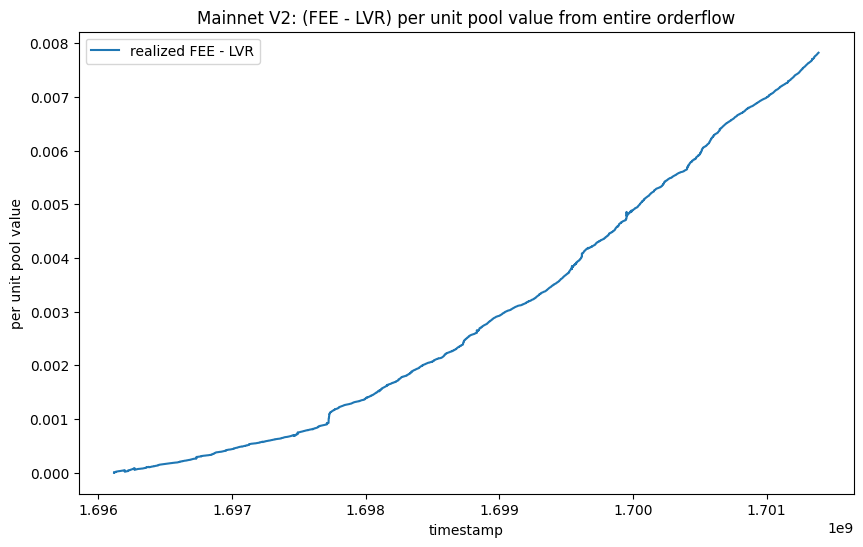

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(
    blocks_price_events["timestamp"],
    (
        (blocks_price_events["FEE"] - blocks_price_events["LVR"])
        / blocks_price_events["poolValue"]
    ).cumsum(),
    label="realized FEE - LVR",
)
# Label the axes
plt.xlabel("timestamp")
plt.ylabel("per unit pool value")
plt.legend()
plt.title("Mainnet V2: (FEE - LVR) per unit pool value from entire orderflow")

# Save & Show the plot
plt.show()